# Pytorch MNIST 

Estudo de uma implementação via torch do dataset MNIST. Ambiente de programação desenvolvido em Anaconda.

Para realizar um treinamento em deep learning o algoritmo precisa seguir os seguintes passos:

1. Training Data ( Inputs e Targets data)
2. Modelo
3. Loss Function (também chamada de criterion)
4. Otimizador

A interação desses passos podem serem vistas como o seguinte diagrama:

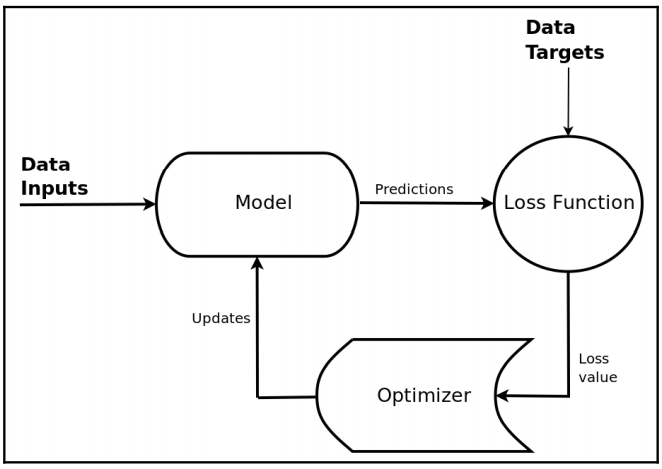

### Banco de dados

In [14]:
# Bobliotecas
import torch
from torchvision import datasets, utils, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

# Pasta do banco de dados
path2data="./data"

# Treino
train_data=datasets.MNIST(path2data, train=True, download=True)

# Transformacoes
data_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1),
                                     transforms.RandomVerticalFlip(p=1),
                                     transforms.ToTensor()])



# Validacao 
train_data=datasets.MNIST(path2data, train=True, download=True,transform=data_transform )

# Verificando Treino/Validacao
x_train, y_train=train_data.data,train_data.targets
x_val,y_val=val_data.data, val_data.targets


# Mais uma dimensao
if len(x_train.shape)==3:
    x_train=x_train.unsqueeze(1)
print(x_train.shape)

if len(x_val.shape)==3:
    x_val=x_val.unsqueeze(1)
print(x_val.shape)



torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


torch.Size([3, 92, 122])


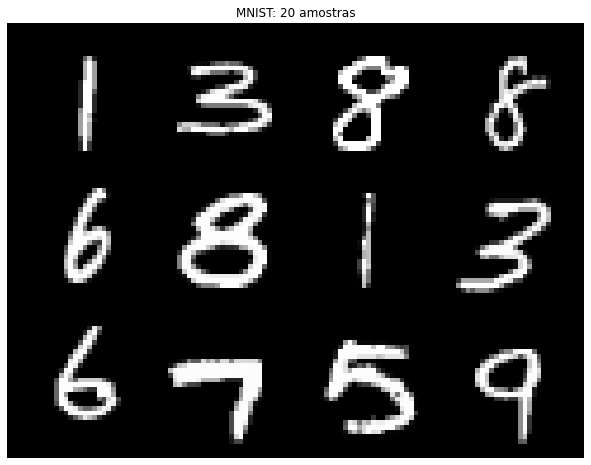

In [15]:
# Mostrar as 12 imagens randomicas

total_img = []
for img in range(0,12):
    total_img.append(random.randint(0,len(x_train)))


def image_show(img):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.figure(figsize=(20,8))
    plt.title('MNIST: 20 amostras')
    plt.axis('off')
    plt.imshow(npimg_tr,interpolation='nearest')
    
x_grid=utils.make_grid(x_train[total_img], nrow=4, padding=2)
print(x_grid.shape)

image_show(x_grid)

In [17]:
# Wrapping Tenrors - Para treinar mais fácil o dataset vale a pena fazer o wrapping dos tensores de entrada e saida
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)

# Data Loaders - É uma boa técnica para inteirar de maneira fácil sobre os datasets durante o treinamento e validação. 
# É preciso especificar um batch size 

from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=8)
val_dl = DataLoader(val_ds, batch_size=8)



### Modelo

In [20]:
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()
print(model)

# Modelo na GPU
device = torch.device("cuda:0")
model.to(device)
print(next(model.parameters()).device)



Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)
cuda:0


### Loss Function

In [25]:
from torch import nn
loss_func = nn.NLLLoss(reduction="sum")

for xb, yb in train_dl:
    # Executar o batch no cuda_device
    xb = xb.type(torch.float).to(device)
    yb = yb.to(device)
    
    # Saida do modelo
    out = model(xb)
    
    # Calcular loss value
    loss = loss_func(out, yb)
    print (loss.item())
    break
loss.backward()

76.07508087158203


### Otimizador

In [27]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-4)

opt.step()
opt.zero_grad()

### Treino e validacao

In [32]:
# Funcao para ajudar a computar o valor da perda por mini-batch

def loss_batch(loss_func, xb, yb, yb_h, opt=None):
    # obter loss
    loss = loss_func(yb_h, yb)
    
    # Obter performace
    metric_b = metrics_batch(yb, yb_h)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), metric_b

# Funcao para ajudar a computar o valor da acuracia por mini-batch

def metrics_batch(target, output):
    pred = output.argmax(dim = 1, keepdim = True)
    corrects=pred.eq(target.view_as(pred)).sum().item()
    
    return corrects

# Funcao para ajudar a computar o valor da perda e das metricas para o dataset

def loss_epoch(model,loss_func,dataset_dl,opt=None):
    loss=0.0
    metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        xb=xb.type(torch.float).to(device)
        yb=yb.to(device)
        # obtain model output
        yb_h=model(xb)
        loss_b,metric_b=loss_batch(loss_func, xb, yb,yb_h, opt)
        loss+=loss_b
        if metric_b is not None:
            metric+=metric_b
    loss/=len_data
    metric/=len_data
    return loss, metric

def train_val(epochs, model, loss_func, opt, train_dl, val_dl):
    for epoch in range(epochs):
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl)
        accuracy=100*val_metric
        print("epoch: %d, train loss: %.6f, val loss: %.6f, accuracy: %.2f" %(epoch, train_loss,val_loss,accuracy))

num_epochs=5
train_val(num_epochs, model, loss_func, opt, train_dl, val_dl)

epoch: 0, train loss: 0.158387, val loss: 0.066370, accuracy: 97.91
epoch: 1, train loss: 0.050986, val loss: 0.053696, accuracy: 98.39
epoch: 2, train loss: 0.028480, val loss: 0.066833, accuracy: 98.28
epoch: 3, train loss: 0.019934, val loss: 0.068695, accuracy: 98.26
epoch: 4, train loss: 0.015069, val loss: 0.047578, accuracy: 98.95


### Salvar o modelo

In [46]:
# Caminho do save dos pesos
path2weights = "./models/weigths.pt"

# Armazenar em um state_dict os arquivo
torch.save(model, path2weights)

# definir modelo: pesos sao iniciados randomicos
_model = Net()

weights = torch.load(path2weights)

_model=torch.load(path2weights)


### Deploy

torch.Size([1, 28, 28])
9 9


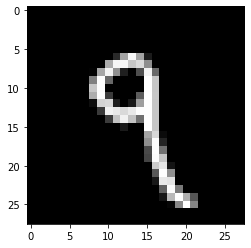

In [50]:
# Selecionar uma imagem

n=random.randint(0, len(x_val))
x= x_val[n]
y=y_val[n]
print(x.shape)
plt.imshow(x.numpy()[0],cmap="gray")

# Unsqueeze para expandir a dimensao da imagem selecionada (1xCxHxW)

x = x.unsqueeze(0)
x = x.type(torch.float)
x = x.to(device)

# Prediction
output = _model(x)
pred = output.argmax(dim=1, keepdim=True)
print (pred.item(),y.item())